# Pool Elo

In [241]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv
from datetime import datetime

# Elo 

In [274]:
# Read Test Dataset 
data = pd.read_csv('data/predatorCLPClean.csv')
data['date'] = pd.to_datetime(data['date'])
fulldf = pd.read_csv("data/fulldf.csv")
fulldf['date'] = pd.to_datetime(fulldf['date'])


In [337]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

players = pd.concat([fulldf.playerA, fulldf.playerB] )
print(players.value_counts().index.unique())
# How many players
nplayers = len(players.value_counts())
nplayers

Index(['Shane Van Boening', 'Darren Appleton', 'Niels Feijen',
       'Dennis Orcollo', 'Jayson Shaw', 'Ralf Souquet', 'Alex Pagulayan',
       'Thorsten Hohmann', 'Albin Ouschan', 'Carlo Biado',
       ...
       'Khaled Al Otaibi', 'Cristopher Tevez Ocamp', 'Kuo Po Cheng',
       'Kengo Suzuki', 'Tony Robles', 'Kim Ga Young', 'Mee Warren',
       'Zhou Long (Poolbillardspieler) [Zhou', 'Craig Hauck', 'RJ Carmona'],
      dtype='object', length=967)


967

In [338]:

def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def run_tournament3(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [339]:
ratings = run_tournament3(fulldf)

In [340]:
ratings
ratings.sort_values(by='ratings', ascending = False)[0:25]


,ratings
Carlo Biado,1830.139686
Niels Feijen,1816.760661
Wu Kun-Lin,1782.527935
Albin Ouschan,1782.396546
David Alcaide,1774.934391
Joshua Filler,1773.507577
Shane Van Boening,1757.348049
Dennis Orcollo,1756.849056
Ko Ping-Chung,1751.339830
Liu Haitao,1749.964396


In [341]:
playersCLP = pd.concat([data.playerA, data.playerB] )


In [342]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in ratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(ratings.index == player)[0][0])
playersindex
names

[18, 8, 751, 21, 2, 5, 339, 31, 12, 1, 76, 23, 915, 100, 93, 14, 116, 40, 378]

In [343]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
print(fullPlayerList)
# fullPlayerList.append("Kristina Tkach")
# fullPlayerList.append("Kelly Fisher")

CLPratings = ratings.iloc[np.array(names)]
print(CLPratings)
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

['Chris Melling', 'Albin Ouschan', 'Kelly Fisher', 'Eklent Kaci', 'Niels Feijen', 'Ralf Souquet', 'Chris Robinson', 'Mieszko Fortunski', 'David Alcaide', 'Darren Appleton', 'Billy Thorpe', 'Naoyuki Oi', 'Kristina Tkach', 'Roberto Gomez', 'Marc Bijsterbosch', 'Alex Kazakis', 'Casper Matikainen', 'Denis Grabe', 'Jasmin Ouschan']
                       ratings
Chris Melling      1587.394534
Albin Ouschan      1782.396546
Kelly Fisher       1480.502286
Eklent Kaci        1746.071956
Niels Feijen       1816.760661
Ralf Souquet       1676.933406
Chris Robinson     1483.400391
Mieszko Fortunski  1684.348034
David Alcaide      1774.934391
Darren Appleton    1602.737187
Billy Thorpe       1537.397987
Naoyuki Oi         1571.593595
Kristina Tkach     1473.105078
Roberto Gomez      1522.774057
Marc Bijsterbosch  1454.764561
Alex Kazakis       1711.912074
Casper Matikainen  1607.777735
Denis Grabe        1543.063776
Jasmin Ouschan     1492.598407


In [344]:
CLPratings.sort_values(by = "ratings", ascending = False)

,ratings
Niels Feijen,1816.760661
Albin Ouschan,1782.396546
David Alcaide,1774.934391
Eklent Kaci,1746.071956
Alex Kazakis,1711.912074
Mieszko Fortunski,1684.348034
Ralf Souquet,1676.933406
Casper Matikainen,1607.777735
Darren Appleton,1602.737187
Chris Melling,1587.394534


In [345]:

def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

import math

def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
        
    
        loglikelihood += math.log(proba)

        
    return(loglikelihood)

In [346]:
get_loglikelihood(data, CLPratings)

-130.3540419217434

In [347]:
data

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP
...,...,...,...,...,...,...,...,...,...
187,187,188,Albin Ouschan,Niels Feijen,5,4,5,2021-03-29,2021 Predator CLP
188,188,189,Naoyuki Oi,David Alcaide,5,4,5,2021-03-29,2021 Predator CLP
189,189,190,Albin Ouschan,Eklent Kaci,5,2,5,2021-03-29,2021 Predator CLP
190,190,191,David Alcaide,Chris Melling,5,2,5,2021-03-29,2021 Predator CLP


# Tuning K

In [348]:
K = np.arange(1, 101, 1)

In [349]:
log_likelihoods = []
for k in K: 
    # Get ratings 
    allratings = run_tournament3(fulldf, K=k)
    
    # Filter ratings 
    CLPratings = allratings.iloc[np.array(names)]
#     CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
    CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
    
    log_likelihoods.append(get_loglikelihood(data, CLPratings))

Optimal K is 17


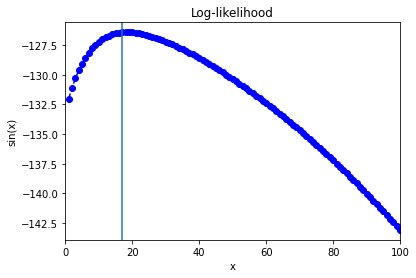

In [350]:
ax = plt.axes()
ax.plot(K, log_likelihoods, '--bo')
ax.axvline(log_likelihoods.index(max(log_likelihoods)))
ax.set(xlim=(0, 100),
       xlabel='x', ylabel='sin(x)',
       title='Log-likelihood');

print("Optimal K is " + str(log_likelihoods.index(max(log_likelihoods))))

In [351]:
bestK = log_likelihoods.index(max(log_likelihoods))

In [352]:
# Get ratings 
allratings = run_tournament3(fulldf, K=bestK)
allratings.sort_values(by='ratings', ascending = False)[0:25]


,ratings
Shane Van Boening,1683.553337
Albin Ouschan,1669.932744
Carlo Biado,1663.503473
Jayson Shaw,1657.314019
Niels Feijen,1651.910057
Dennis Orcollo,1645.582453
Joshua Filler,1632.157562
Eklent Kaci,1628.637016
David Alcaide,1623.298264
Liu Haitao,1620.831882


In [353]:
# Filter ratings 
CLPratings = allratings.iloc[np.array(names)]
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
CLPratings.sort_values(by='ratings', ascending = False)

,ratings
Albin Ouschan,1669.932744
Niels Feijen,1651.910057
Eklent Kaci,1628.637016
David Alcaide,1623.298264
Alex Kazakis,1611.845789
Ralf Souquet,1585.655580
Mieszko Fortunski,1579.881227
Darren Appleton,1571.791423
Naoyuki Oi,1539.669029
Chris Melling,1538.998907


# Update Posterior Ratings after Predator CLP

In [317]:

def run_tournament_with_prior_ratings(data, priorratings, ELO_WIDTH = ELO_WIDTH, K=bestK):
    

    # Initialize Elo Ratings
    elo_ratings = priorratings

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        k=K
#         if row['isSemi'] == True: 
#             k = K*2
#         elif row['isFinal'] == True: 
#             k = K*3
#         else: 
#             k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings.loc[winner][0], elo_ratings.loc[loser][0], k, ELO_WIDTH)
        elo_ratings.loc[winner][0] = new_winner_rating
        elo_ratings.loc[loser][0] = new_loser_rating
    return(elo_ratings)

In [318]:
posterior_ratings = run_tournament_with_prior_ratings(data, priorratings = CLPratings)

In [319]:
posterior_ratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1681.808890
Albin Ouschan,1680.261770
David Alcaide,1664.224258
Niels Feijen,1636.157196
Alex Kazakis,1608.697010
Chris Melling,1584.158841
Naoyuki Oi,1575.888423
Mieszko Fortunski,1542.982168
Darren Appleton,1541.004199
Ralf Souquet,1539.958227


In [ ]:
# Things to Extend 
    # Figure out how to extend K 
        # K varying as a function of scoreline
    # Glicko 
        
    # Data collection 


# Sandbox Code 

In [70]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

In [69]:
def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

In [98]:

def run_tournament(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, k=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        if row['isSemi'] == True: 
            k = K*2
        elif row['isFinal'] == True: 
            k = K*3
        else: 
            k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [99]:
ratings = run_tournament()

KeyError: 'Kelly Fisher'

In [100]:
ratings.sort_values(by='ratings', ascending = False)

,ratings
Shannon Murphy,1475.0
Robby Foldvari,1475.0
Jang Moonseok,1475.0
Francois Ellis,1475.0
Himanshu Jain,1475.0
...,...
Albin Ouschan,800.0
Jayson Shaw,775.0
Alex Pagulayan,750.0
Dennis Orcollo,750.0


In [101]:
# Train-Test Split
winnersgroup = data[data.Group == 8]
prelims = data[data.Group != 8]

In [102]:
ratingsPrelims = run_tournament(data=prelims)

KeyError: 'Kelly Fisher'

In [103]:
ratingsPrelims
ratingsPrelims.sort_values(by='ratings', ascending = False)


NameError: name 'ratingsPrelims' is not defined